#### Project Summary: 

The environmental factors below do not signiciantly influence estimates of deer density made from spotlight surveys.  Temperature was found to be the most influential predictor from a multiple linear regression model (MLR) and two machine learning models (random forest and gradient boosting).  The R2 (i.e., proportion of variance explained by the model) of the selected linear model was poor (~ 0.10).  However, temperature was found to be a statistically significant predictor (p < 0.001).  The selected MLR found that for every 1 degree fahreheit increase in temperature, there was a 0.80 decrease in the deer density. Environmental factors: 

* month of the year (numerical)
* temperature (numerical)
* wind (boolean)
* cloud cover (index)
* rain (boolean)
* snow (boolean)
* fog (boolean)
* moon phase (index)

#### Dataset: 

This is deer spotlight survey data collected by the Department of the Interior in Great Smoky Mountains National Park from 1993-2003.

####  Implications: 

Environmental factors (i.e., temperature, wind, cloud, rain, snow, fog, and moon phase) do not influence estimates of deer density enough to warrant cancelling a deer survey.  More research is needed on the influence of severe weather events (e.g., heavy rain and high wind) on estimates of deer density.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("Observations.csv")
data

,date,start,finish,sunset,temperature,windy,clouds,rainy,snow,fog,...,Coyote,Opossum,Skunk,Wild_Hog,Red_Wolf,Gray_Fox,Rabbit,Bobcat,Area,deer_dens
0,1/25/1993,1/0/1900,1/0/1900,1/0/1900,36.0,False,1,False,False,False,...,0,0,0,0,5,2,1,0,470.0,4.519231
1,2/22/1993,1/0/1900,1/0/1900,1/0/1900,46.0,False,1,False,False,False,...,0,0,1,0,0,0,1,0,470.0,2.526882
2,3/8/1993,1/0/1900,1/0/1900,1/0/1900,56.5,False,3,False,False,False,...,0,0,6,0,0,1,4,0,470.0,1.690647
3,3/29/1993,1/0/1900,1/0/1900,NaN,64.0,False,1,False,False,False,...,0,0,6,0,0,1,2,0,470.0,1.991525
4,5/11/1993,1/0/1900,1/0/1900,1/0/1900,65.0,False,2,False,False,False,...,0,0,0,0,0,0,0,0,470.0,1.843137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,9/10/2003,1/0/1900,1/0/1900,1/0/1900,60.0,False,1,False,False,False,...,2,0,0,0,0,0,1,0,470.0,24.736842
213,9/27/2003,1/0/1900,1/0/1900,1/0/1900,62.0,False,0,True,False,False,...,1,0,0,0,0,1,0,0,470.0,7.966102
214,10/14/2003,1/0/1900,NaN,1/0/1900,56.0,True,3,False,False,False,...,7,0,0,0,0,0,0,0,470.0,3.983051
215,10/29/2003,1/0/1900,1/0/1900,1/0/1900,40.0,False,3,False,False,False,...,6,0,0,1,0,0,0,0,470.0,21.363636


In [3]:
data[["month","day","year"]] = data["date"].str.split("/",expand=True)

(-1.0, 50.0)

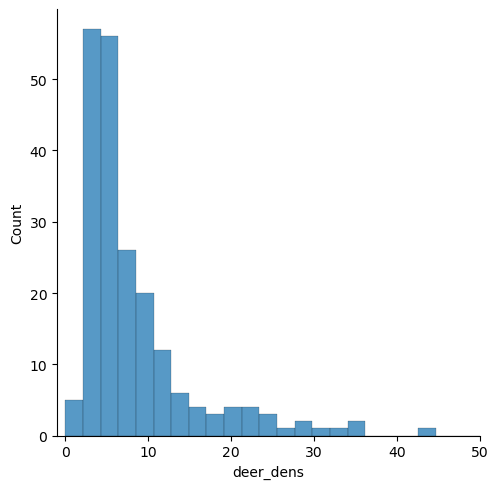

In [4]:
sns.displot(data['deer_dens']) # not normally distributed, skewed left
plt.xlim(-1, 50)

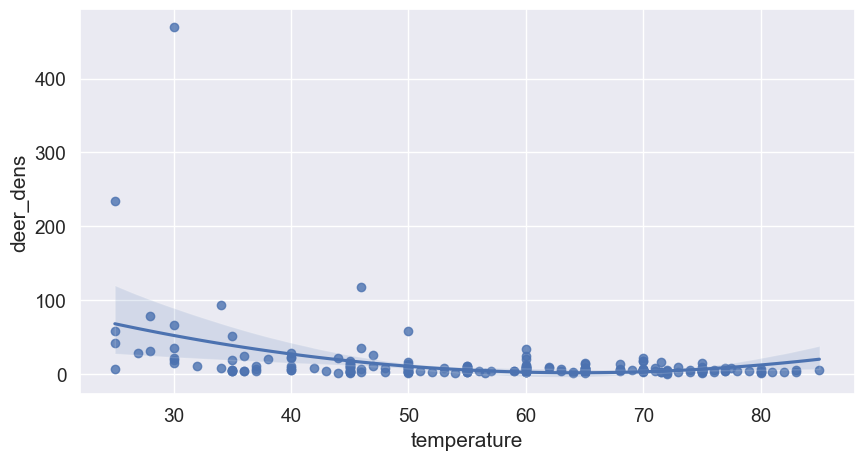

In [5]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'temperature', y = 'deer_dens', data = data, order=2)
plt.title('', fontsize=20)
plt.show()

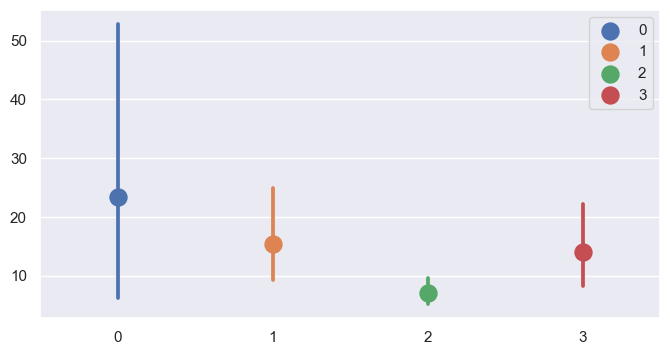

In [6]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="clouds", y="deer_dens", hue = "clouds", data=data, scale=1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

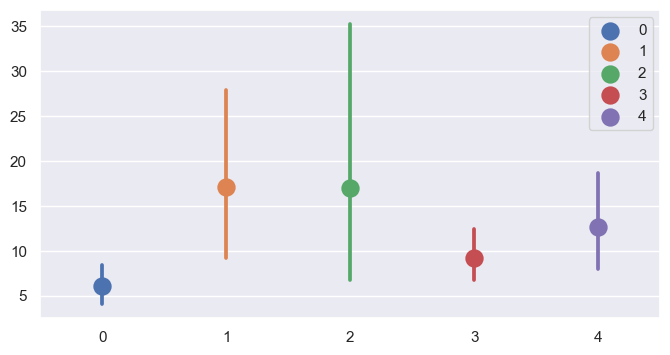

In [7]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="moon", y="deer_dens", hue = "moon", data=data, scale= 1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

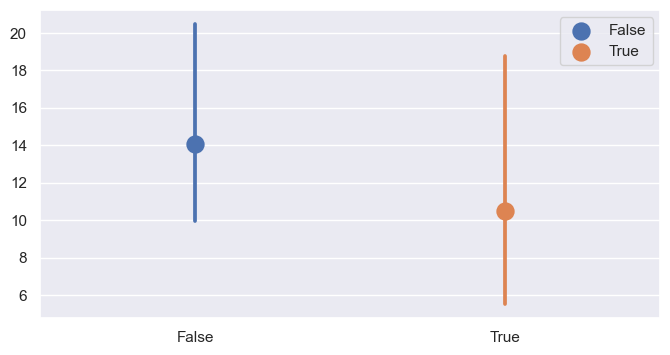

In [8]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="windy", y="deer_dens", hue = "windy", data=data, scale= 1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

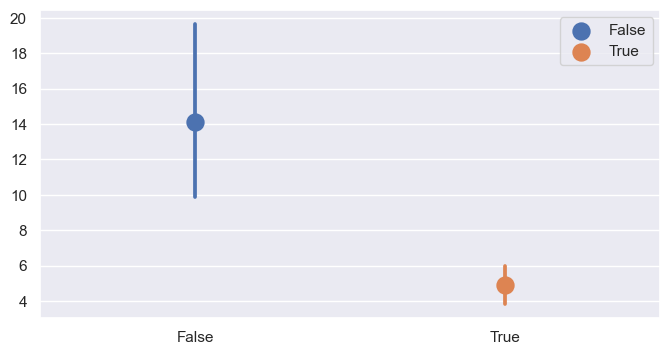

In [9]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="rainy", y="deer_dens", hue="rainy", data=data, scale= 1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

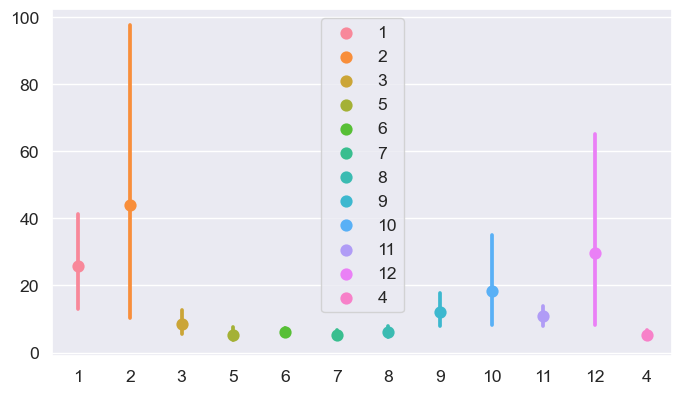

In [10]:
sns.set(rc={"figure.figsize":(8, 4.5)}, font_scale = 1.15) 
p = sns.pointplot(x="month", y="deer_dens", hue="month", data=data, scale= 1)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

In [11]:
data['windy'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)
data['rainy'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)
data['snow'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)
data['fog'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)

In [12]:
data.drop(['date','start','finish','sunset','spotlight','notes',
           'conditions','observers','total_deer','Raccoon','Bear',
           'Coyote','Opossum','Skunk','Wild_Hog','Red_Wolf','Gray_Fox',
           'Rabbit','Bobcat','Area'],axis=1, inplace=True)

In [13]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
temperature : 0 NaN
windy : 0 NaN
clouds : 0 NaN
rainy : 0 NaN
snow : 0 NaN
fog : 0 NaN
moon : 0 NaN
deer_dens : 0 NaN
month : 0 NaN
day : 0 NaN
year : 0 NaN


C:\Users\wpson\AppData\Local\Temp\ipykernel_20784\2810399297.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":12})


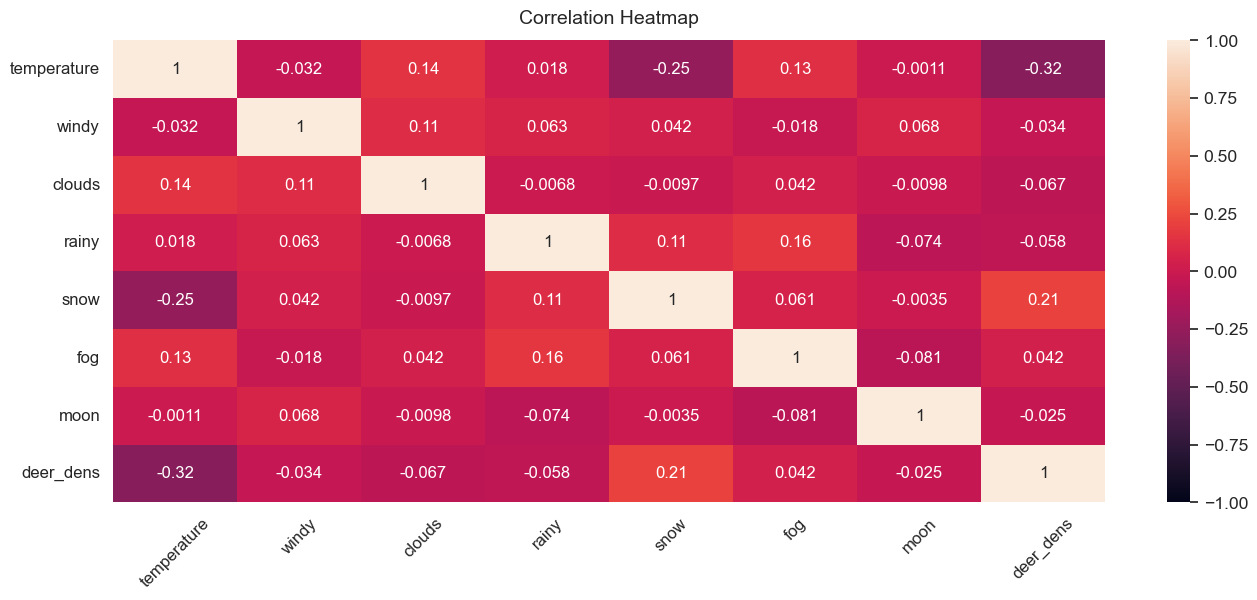

In [14]:
# Looking for multicollineatity among environmental variables.  Dropping highly correlated variables.

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":12})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

No multicollinearity detected, thus, no variables were dropped.

In [15]:
X = data[['month','temperature','windy','clouds','rainy','snow','fog','moon']] 
y = data['deer_dens']

Fit several linear regression models and select final model

In [16]:
lm1 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow + fog + moon', data = data).fit()
lm2 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow + fog', data = data).fit()
lm3 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow', data = data).fit()
lm4 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy', data = data).fit()
lm5 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds', data = data).fit()
lm6 = smf.ols(formula = 'deer_dens ~ month + temperature + windy', data = data).fit()
lm7 = smf.ols(formula = 'deer_dens ~ month + temperature', data = data).fit()

lm8 = smf.ols(formula = 'deer_dens ~ month + windy + clouds + rainy + snow + fog + moon', data = data).fit()
lm9 = smf.ols(formula = 'deer_dens ~ month + clouds + rainy + snow + fog + moon', data = data).fit()
lm10 = smf.ols(formula = 'deer_dens ~ month + rainy + snow + fog + moon', data = data).fit()
lm11 = smf.ols(formula = 'deer_dens ~ month + snow + fog + moon', data = data).fit()
lm12 = smf.ols(formula = 'deer_dens ~ month + fog + moon', data = data).fit()
lm13 = smf.ols(formula = 'deer_dens ~ month + moon', data = data).fit()

lm14 = smf.ols(formula = 'deer_dens ~ month + temperature + clouds + rainy + snow + fog + moon', data = data).fit()
lm15 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + rainy + snow + fog + moon', data = data).fit()
lm16 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + snow + fog + moon', data = data).fit()
lm17 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + fog + moon', data = data).fit()
lm18 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow + moon', data = data).fit()

lm19 = smf.ols(formula = 'deer_dens ~ temperature', data = data).fit()


print("aic lm1: ", lm1.aic) 
print("aic lm2: ", lm2.aic)
print("aic lm3: ", lm3.aic)
print("aic lm4: ", lm4.aic)
print("aic lm5: ", lm5.aic)
print("aic lm6: ", lm6.aic)
print("aic lm7: ", lm7.aic) 
print("aic lm8: ", lm8.aic) 
print("aic lm9: ", lm9.aic)
print("aic lm10:", lm10.aic)
print("aic lm11:", lm11.aic)
print("aic lm12:", lm12.aic)
print("aic lm13:", lm13.aic)
print("aic lm14:", lm14.aic)
print("aic lm15:", lm15.aic)
print("aic lm16:", lm16.aic)
print("aic lm17:", lm17.aic)
print("aic lm18:", lm18.aic)
print("aic lm19:", lm19.aic)  # lowest AIC score

aic lm1:  2177.3891875997715
aic lm2:  2175.4990471244955
aic lm3:  2174.4356348595493
aic lm4:  2178.7799989774767
aic lm5:  2177.3855611651675
aic lm6:  2176.1520626943893
aic lm7:  2174.5853269944837
aic lm8:  2186.995369118308
aic lm9:  2185.9728402825276
aic lm10: 2185.0799855161176
aic lm11: 2185.420821190907
aic lm12: 2191.7303998251728
aic lm13: 2191.4779686928855
aic lm14: 2175.7924002863865
aic lm15: 2176.150137449389
aic lm16: 2176.8923127026515
aic lm17: 2181.4552435424075
aic lm18: 2176.2662082704737
aic lm19: 2168.3095860468557


In [17]:
print("aic lm1: ", lm1.bic) 
print("aic lm2: ", lm2.bic)
print("aic lm3: ", lm3.bic)
print("aic lm4: ", lm4.bic)
print("aic lm5: ", lm5.bic)
print("aic lm6: ", lm6.bic)
print("aic lm7: ", lm7.bic)
print("aic lm8: ", lm8.bic) 
print("aic lm9: ", lm9.bic)
print("aic lm10:", lm10.bic)
print("aic lm11:", lm11.bic)
print("aic lm12:", lm12.bic)
print("aic lm13:", lm13.bic)
print("aic lm14:", lm14.bic)
print("aic lm15:", lm15.bic)
print("aic lm16:", lm16.bic)
print("aic lm17:", lm17.bic)
print("aic lm18:", lm18.bic)
print("aic lm19:", lm19.bic) # lowest BIC score

aic lm1:  2241.60723731704
aic lm2:  2236.3371994882236
aic lm3:  2231.893889869737
aic lm4:  2232.858356634124
aic lm5:  2228.0840214682744
aic lm6:  2223.470625643956
aic lm7:  2218.52399259051
aic lm8:  2247.8335214820363
aic lm9:  2243.4310952927153
aic lm10: 2239.158343172765
aic lm11: 2236.119281494014
aic lm12: 2239.0489627747393
aic lm13: 2235.4166342889116
aic lm14: 2236.6305526501146
aic lm15: 2236.9882898131173
aic lm16: 2237.7304650663796
aic lm17: 2242.2933959061356
aic lm18: 2237.104360634202
aic lm19: 2175.0693807539365


AIC and BIC reported lowest score for lm19, which only includes the predictor, 'temperature'

In [18]:
lm19.summary() # Selected model has poor fit to data; R-squared: 0.102

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              deer_dens   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     24.34
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           1.62e-06
Time:                        15:37:48   Log-Likelihood:                -1082.2
No. Observations:                 217   AIC:                             2168.
Df Residuals:                     215   BIC:                             2175.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      59.6391      9.645      6.183      0.000      40.628      78.650
temperature    -0.8032      0.163     -4.933      0.000      -1.124      -0.482
==============================================================================
Omnibus:                      385.819   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104027.876
Skew:                           9.350   Prob(JB):                         0.00
Kurtosis:                     108.621   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
pred = lm19.predict(X) # generating predictions from model
print(pred)

0      30.723145
1      22.690931
2      14.257106
3       8.232946
4       7.429724
         ...    
212    11.445831
213     9.839388
214    14.658717
215    27.510260
216    35.542474
Length: 217, dtype: float64


In [20]:
mae = mean_absolute_error(y, pred) # assessing mean absolute error (i.e., the average error between predicted values and actual values)
print(mae)

13.093519852098817


In [21]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

Using KFold cross validation to assess overfit

In [22]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [38.05041201  9.72828245 12.03956402  6.13457854  4.26940806  2.99232608
 19.16526236  6.93235216 18.6182916  25.29351003]
MAE average:  14.322398729171505


In [23]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [37.96485012  8.5941504  10.61453546  7.54330526  7.90652676  2.93729842
 29.93939007  5.2208895  15.4124796  30.70625533]
MAE average:  15.683968090562553


In [24]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wpson\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\sklearn.py", line 761, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\sklearn.py", line 286, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\sklearn.py", line 775, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\core.py", line 616, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py", line 707, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py", line 297, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py", line 242, in _transform_pandas_df
    raise ValueError(msg + ', '.join(bad_fields))
ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.month


MAEs are all over the place and the xgbr model failed to fit. 

Tuning hyperparameters via grid search 

In [25]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [26]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [27]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [28]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [29]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [30]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [31]:
pred_gs_rf = gs_rf.predict(X)
pred_gs_gb = gs_gb.predict(X)

mae_gs_rf = mean_absolute_error(y, pred_gs_rf)
mae_gs_gb = mean_absolute_error(y, pred_gs_gb)

print(mae_gs_rf) # lowest mae
print(mae_gs_gb)

4.888406862091703
8.907655714130767


Assess if predictors have similar feature importance scores among models

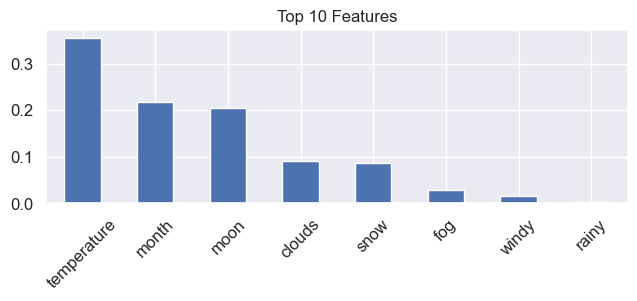

In [32]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 12
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

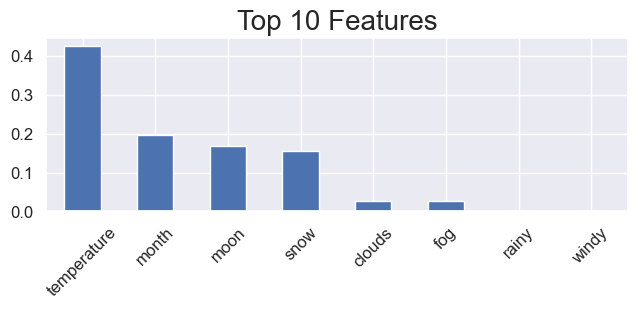

In [33]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 20
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()